# E2a: Küchentischversuch zum Laval-Rotor

Name: Bastian Bickel 
Datum: 12.01.2024 

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:
Ist es möglich mithilfe des Beschleunigungssensors die Signale von einer Waschmaschine und eines Handyweckers, z.B. Töne und Vibrationen, zu erfassen und diese in ihre Frequenzen zu zerlegen, sowie allgemein das Signalverhalten anhand der Beschleunigung über die Zeit zuordnen und nachvollziehen zu können? 

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="figures/Bild_Waschmaschine.jpg" width="500">

- Beschreibung des Aufbaus: Beschleunigungssensor wird an der Waschmaschine befestigt und mit dem Pi verbunden
- Vorgangsbeschreibung: Nach Anlaufen der Waschmaschine die 20 Sekunden lange Messung durch den am Pi angeschlossenen Beschleunigungssensor. Nach 20 Sekunden endet die Messung automatisch und die Messwerte werden abgespeichert.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [1]:
import h5py
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [2]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = "measurement_data/" # replace None by the relative path to the first object's folder
h5_file_name = "data_20240106_141325_YourNameWithoutWhiteSpaces_Waschmaschine.h5" # replace None by the filename of the hdf5-file
# ---------------------------------------------------------------------------------------------#1-end

In [3]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20240108_123004_Bastian_Bickel_Handywecker/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240108_123004_Bastian_Bickel_Handywecker/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20240108_123004_Bastian_Bickel_Handywecker/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1ee98cdb-90b8-6e7c-8b1d-a635d3343ab2": {
    "type": "probe",
    "name": "Waschmaschine",
    "comment": "",
    

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [4]:
#öffenen der hdf5-Datei des Waschmaschinenversuchs
f = h5py.File("measurement_data/data_20240106_141325_Bastian_Bickel_Waschmaschine/data_20240106_141325_YourNameWithoutWhiteSpaces_Waschmaschine.h5", 'r')

#Auslesen der Beschleunigungen in x-, y- und z-Richtung sowie Zeitvektor
x = np.array(f["RawData"]["1ee847be-fddd-6ee4-892a-68c4555b0981"]["acceleration_x"])
y = np.array(f["RawData"]["1ee847be-fddd-6ee4-892a-68c4555b0981"]["acceleration_y"])
z = np.array(f["RawData"]["1ee847be-fddd-6ee4-892a-68c4555b0981"]["acceleration_z"])
vec_time_W = np.array(f["RawData"]["1ee847be-fddd-6ee4-892a-68c4555b0981"]["timestamp"])


#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [5]:
#Betrag der Beschleunigung berechnen
vec_accel_W = get_vec_accel(x, y, z)

#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

Text(0, 0.5, 'Zeitabstände zwischen Messungen')

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


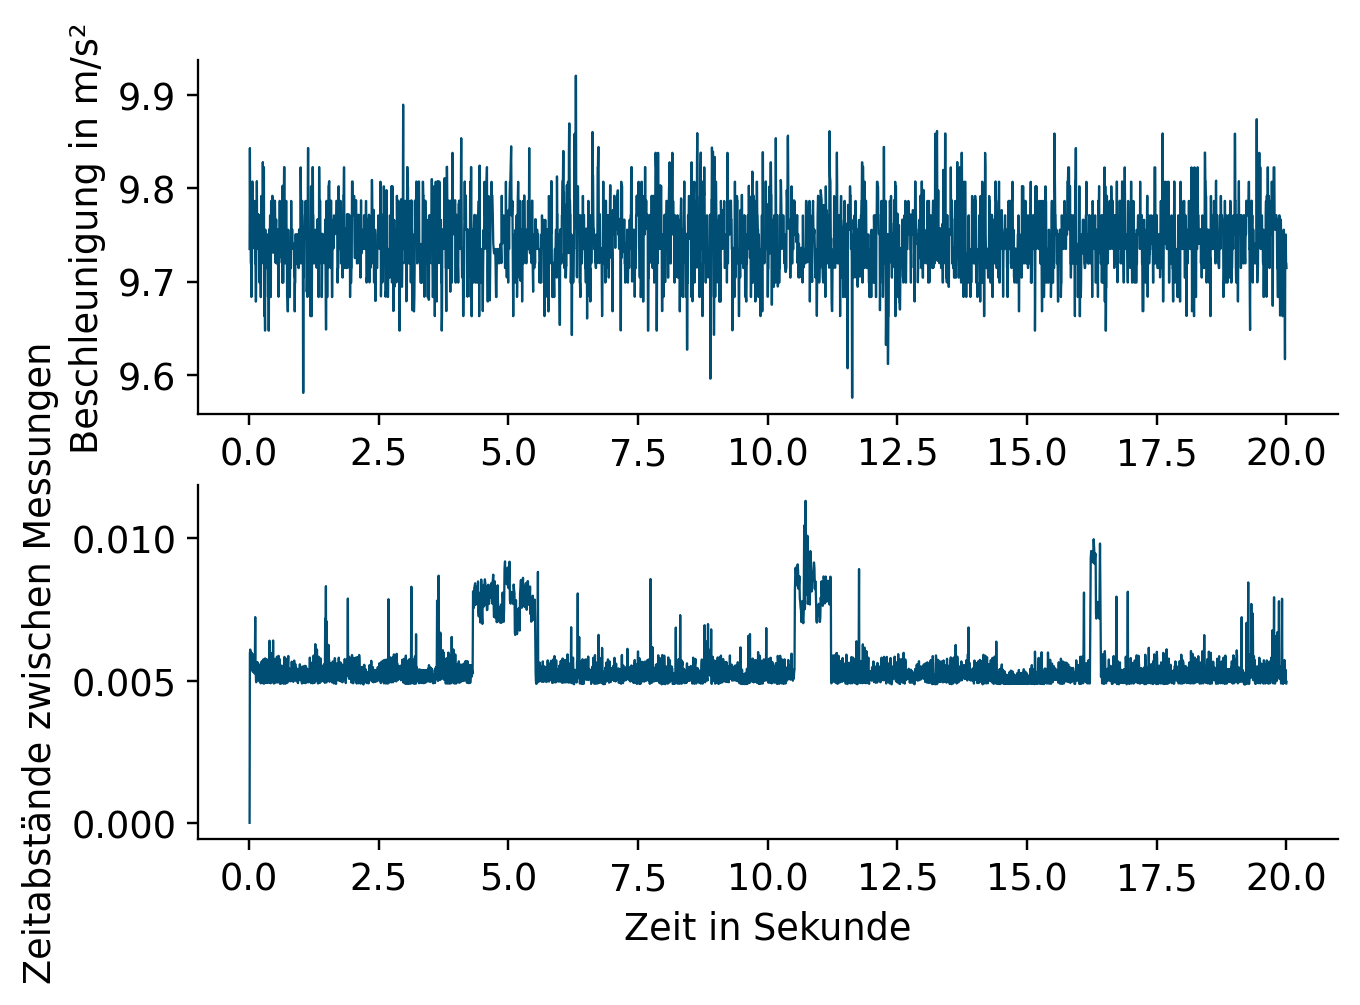

In [6]:
#Subplot mit 2 Plots erstellen
fig, axs = plt.subplots(2)

#ersten Plot mit Betrag der Beschleunigung über Zeit erstellen
axs[0].plot(vec_time_W, vec_accel_W)
plt.xlabel("Zeit in Sekunde")
axs[0].set_ylabel("Beschleunigung in m/s²")

vec_time_d = []
for i, j in enumerate(vec_time_W):
    
    vec_time_i = j - vec_time_W[i-1]
    vec_time_d.append(vec_time_i)
    vec_time_d[0] = 0
    
#zweiten Plot mit zeitlichen Abständen zwischen Messungen über Zeit erstellen
axs[1].plot(vec_time_W, vec_time_d)
plt.xlabel("Zeit in Sekunde")
axs[1].set_ylabel("Zeitabstände zwischen Messungen")

#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

Text(0, 0.5, 'interpolierte Beträge der Beschleunigung')

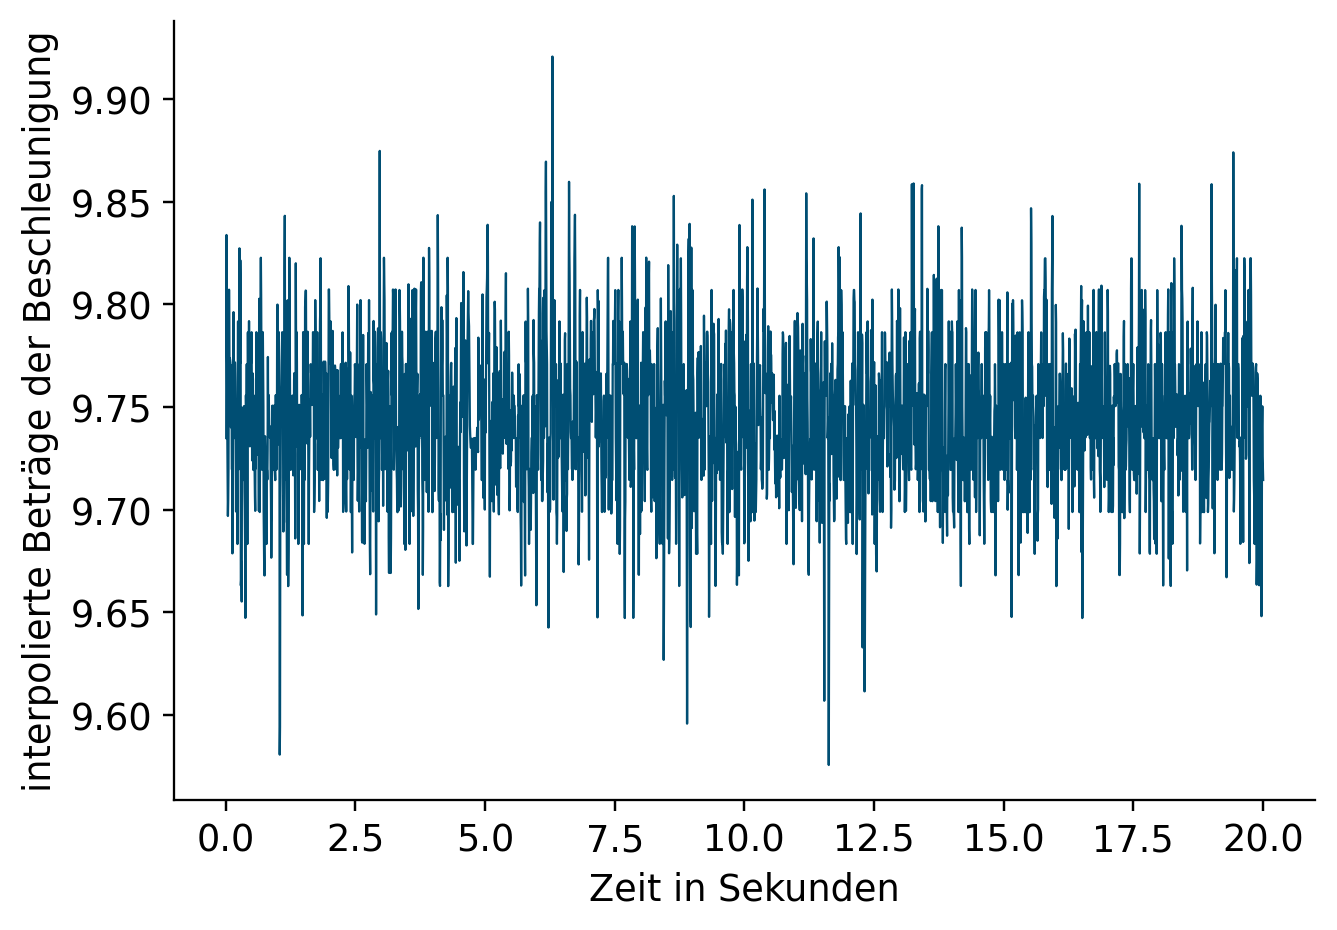

In [7]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.

#interpolieren der Daten um gleichmäßige Zeitabstände zwischen Messungen zu erhalten
time, data = interpolation(vec_time_W, vec_accel_W)

#plotten der interpolierten Daten über die Zeit
plt.plot(time, data)
plt.xlabel("Zeit in Sekunden")
plt.ylabel("interpolierte Beträge der Beschleunigung")

#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

Text(0, 0.5, 'Amplitude')

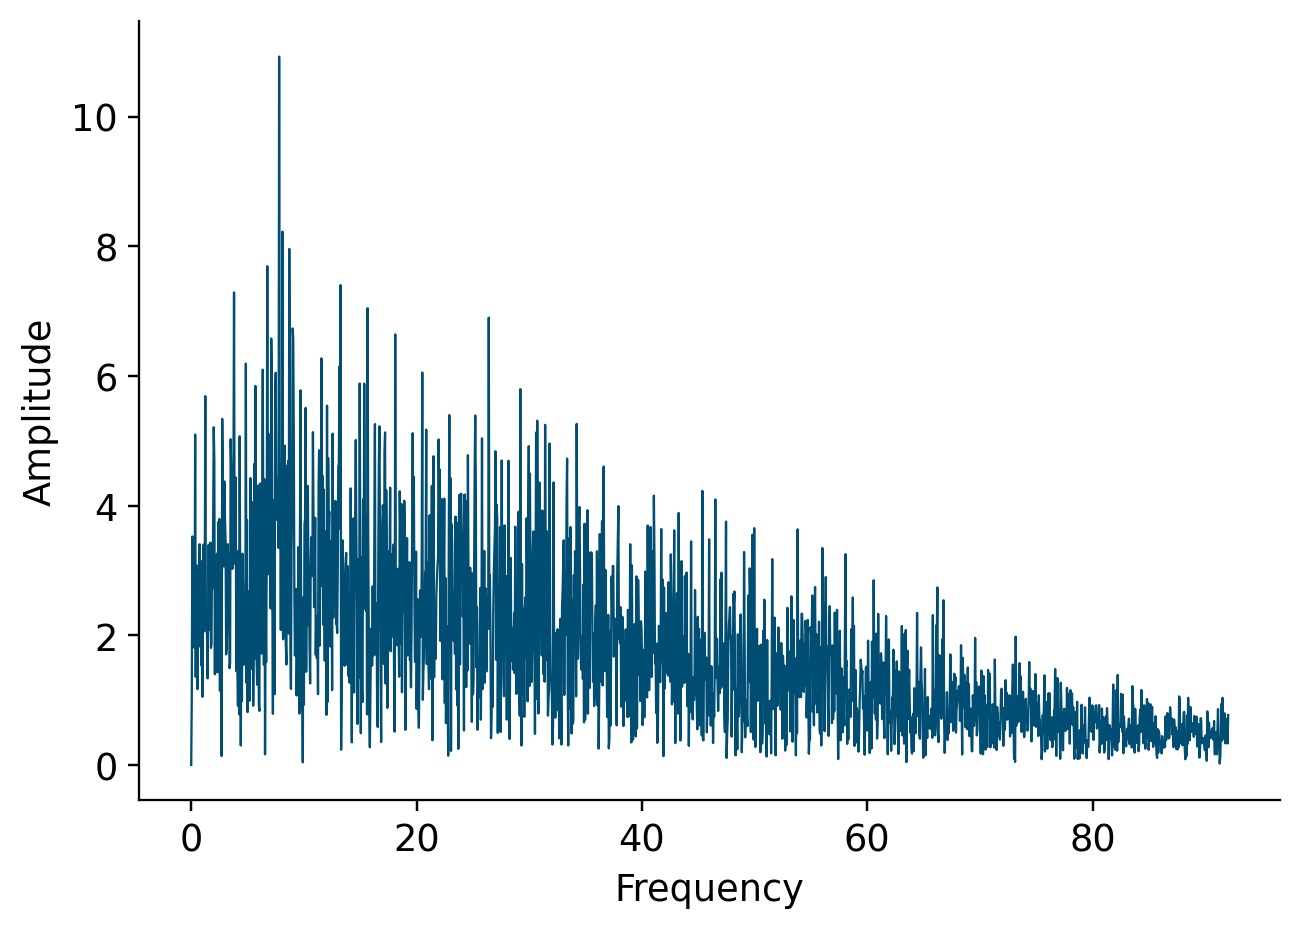

In [8]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
#Mittelwert der Daten bilden
data_m = np.mean(data)

#Mittelwert auf Null setzen
data = data - data_m

#Amplitude und Frequenz berechnen
Amplitude, Frequency = my_fft(data, time)

#plotten der Amplitude über die Frequenz 
plt.plot(Frequency, Amplitude)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="figures/Bild_Handywecker.jpg" width="500">


- Beschreibung des Aufbaus: Beschleunigungssensor wird am Handy befestigt und mit dem Pi verbunden
- Vorgangsbeschreibung: Nach Beginn des Handyweckers startet die 20 Sekunden lange Messung durch den am Pi angeschlossenen Beschleunigungssensor. Nach 20 Sekunden endet die Messung automatisch und die Messwerte werden abgespeichert.

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [9]:
path_measurement_folder = "measurement_data/"
h5_file_name = "data_20240108_123004_YourNameWithoutWhiteSpaces_Handywecker.h5"

In [10]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))

{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20240108_123004_Bastian_Bickel_Handywecker/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240108_123004_Bastian_Bickel_Handywecker/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20240108_123004_Bastian_Bickel_Handywecker/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1ee98cdb-90b8-6e7c-8b1d-a635d3343ab2": {
    "type": "probe",
    "name": "Waschmaschine",
    "comment": "",
    

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [11]:
#öffenen der hdf5-Datei des Waschmaschinenversuchs
f = h5py.File("measurement_data/data_20240108_123004_Bastian_Bickel_Handywecker/data_20240108_123004_YourNameWithoutWhiteSpaces_Handywecker.h5", 'r')

#Auslesen der Beschleunigungen in x-, y- und z-Richtung sowie Zeitvektor
x = np.array(f["RawData"]["1ee847be-fddd-6ee4-892a-68c4555b0981"]["acceleration_x"])
y = np.array(f["RawData"]["1ee847be-fddd-6ee4-892a-68c4555b0981"]["acceleration_y"])
z = np.array(f["RawData"]["1ee847be-fddd-6ee4-892a-68c4555b0981"]["acceleration_z"])
vec_time_H = np.array(f["RawData"]["1ee847be-fddd-6ee4-892a-68c4555b0981"]["timestamp"])

#### 2. Betrag der Beschleunigung berechnen


In [12]:
#Betrag der Beschleunigung berechnen
vec_accel_H = get_vec_accel(x, y, z)

#### 3. Darstellung der Messdaten

Text(0, 0.5, 'Zeitabstände zwischen Messungen')

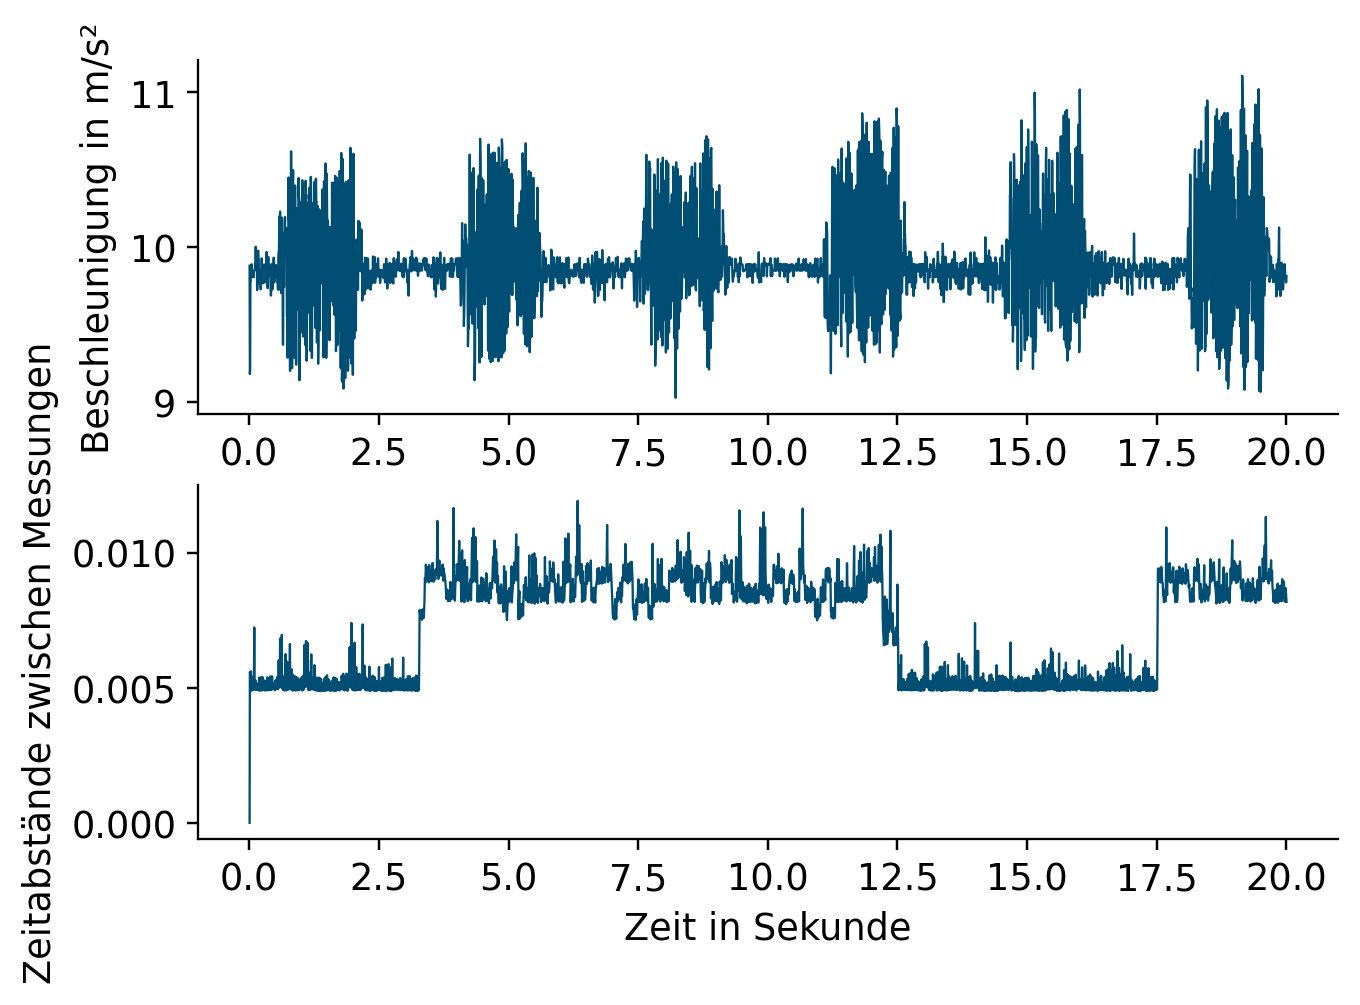

In [13]:
#ersten Eintrag zu Durchschnitt ändern, da dieser zuvor Null ist und zu stark aus dem Muster fällt und somit als Messfehler betrachtet wird
vec_accel_H[0] = np.mean(vec_accel_H)

#Subplot mit 2 Plots erstellen
fig, axs = plt.subplots(2)

#ersten Plot mit Betrag der Beschleunigung über Zeit erstellen
axs[0].plot(vec_time_H, vec_accel_H)
plt.xlabel("Zeit in Sekunde")
axs[0].set_ylabel("Beschleunigung in m/s²")

vec_time_d = []
for i, j in enumerate(vec_time_H):
    
    vec_time_i = j - vec_time_H[i-1]
    vec_time_d.append(vec_time_i)
    vec_time_d[0] = 0
    
#zweiten Plot mit zeitlichen Abständen zwischen Messungen über Zeit erstellen
axs[1].plot(vec_time_H, vec_time_d)
plt.xlabel("Zeit in Sekunde")
axs[1].set_ylabel("Zeitabstände zwischen Messungen")

#### 4. Interpolation der Messwerte



Text(0, 0.5, 'interpolierte Beträge der Beschleunigung')

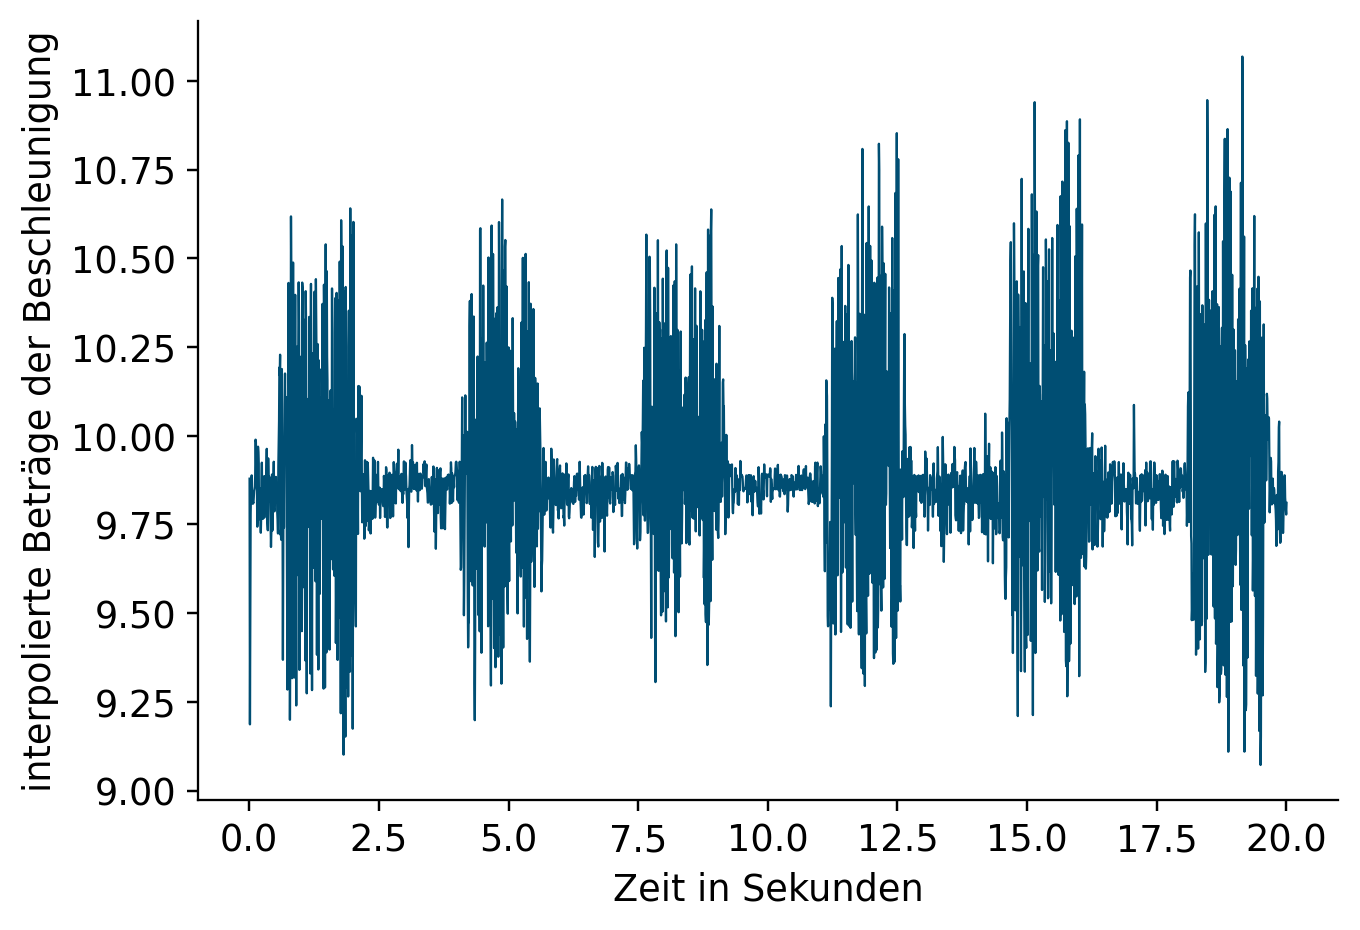

In [14]:
#interpolieren der Daten um gleichmäßige Zeitabstände zwischen Messungen zu erhalten
time, data = interpolation(vec_time_H, vec_accel_H)

#plotten der interpolierten Daten über die Zeit
plt.plot(time, data)
plt.xlabel("Zeit in Sekunden")
plt.ylabel("interpolierte Beträge der Beschleunigung")

#### 5 & 6. FFT durchführen und graphisch darstellen


Text(0, 0.5, 'Amplitude')

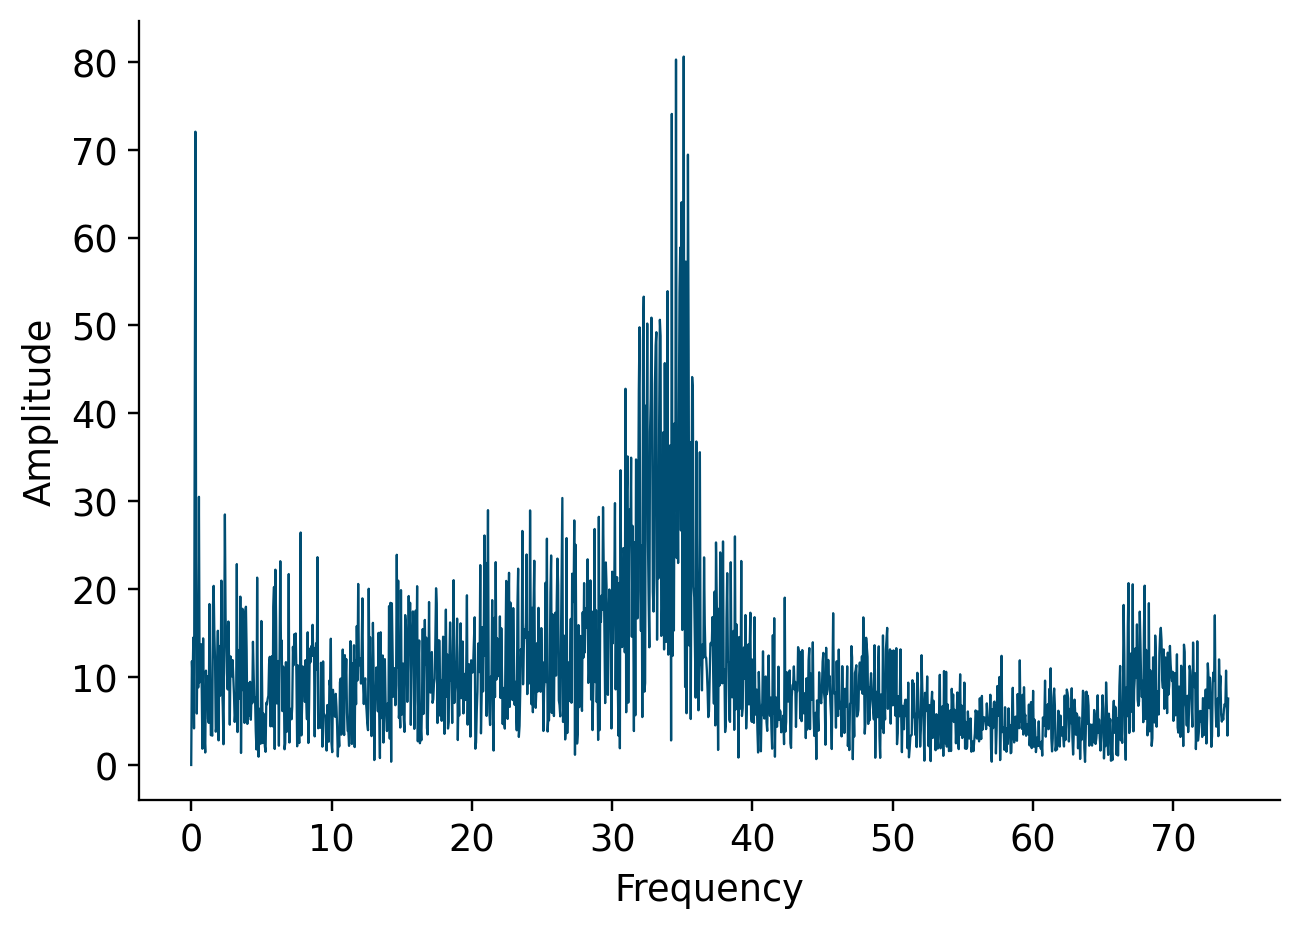

In [15]:
#Mittelwert der Daten bilden
data_m = np.mean(data)

#Mittelwert auf Null setzen
data = data - data_m

#Amplitude und Frequenz berechnen
Amplitude, Frequency = my_fft(data, time)

#plotten der Amplitude über die Frequenz
plt.plot(Frequency, Amplitude)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Durch die Messung des Beschleunigungssensors konnte das Siganlverhalten von einer Waschmaschine und eines Handyweckers nachvollzogen werden, bei letzterem etwas besser als bei der Waschmaschine. Bei dieser erkennt man über die gesamte Messzeit dauerhafte Ausschläge der Beschleunigung und somit eine andauernde, größtenteils gleichmäßige Vibration. Anders beim Handywecker, bei dem deutlich erkennbare Phasen von stärkere Vibration und Klingelton, sowie schwächerer Vibration ohne Ton sichtbar sind. Somit konnte das Signalverhalten, vorallem beim Handywecker, graphisch sichtbar gemacht werden.
Ungenauigkeiten sind vorallem über die unregelmäßigen Messintervalle des PI´s aufgetreten, wie man ebenfalls graphisch erkennen kann. Um eine Fourier-Transformation durchzuführen wurden die Messdaten deshalb noch interpoliert, um für gleichmäßige Zeitschritte zu sorgen. Mit der Fourier-Transformation konnten dann die Signale in ihre einzelnen Frequenzen zerlegt werden, was jeweils in den letzten Graphen der Versuche dargestellt wird. Dabei handelt sich sich grötenteils um kleine Frequenzen, welche menschlich wahrnehmbar sind.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Der Versuch war gut verständlich und einfach mit im Haushalt auffindbaren Gegenständen durchzuführen. Zudem fand ich es sehr gut die Fourier-Transformation nun auch mal anwendungsbezogen verwenden und dadurch besser verstehen zu können, da mir diese bisher nur innnerhalb der Mathevorlesungen- und Übungsaufgaben bekannt war. Vom zeitlichen Aufwand und mit den bereitgestellten Hilfestellungen, Hinweisen und teilweise vorgefertigtem Code war der Versuch gut machbar und interessant zu bearbeiten.